<a href="https://colab.research.google.com/github/EA-park/AIFFEL/blob/main/%5BExp_05%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#루브릭

1. 이미지 분류기 모델이 성공적으로 만들어졌는가?
 - 학습과정이 정상적으로 수행되었으며, 학습 결과에 대한 그래프를 시각화(ex. train acc / train loss / val acc / val loss 등) 해 보았음

2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?
 - 오버피팅 극복을 위하여 데이터셋의 다양성, 정규화 등을 2가지 이상 시도해보았음

3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?
 - 60% 이상 도달하였음

In [9]:
# set the working directory
from os.path import join
from google.colab import drive

#
from PIL import Image
import glob
import os

# instruct models
import tensorflow as tf
from tensorflow import keras
import numpy as np

# print images
import matplotlib.pyplot as plt 

print(tf.__version__)
print(np.__version__)

2.8.2
1.21.6


경로 설정하기

In [2]:
ROOT = '/content/gdrive'
drive.mount(ROOT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
PROJ = 'MyDrive/AIFFEL/Exp-05'
WORKING_DIR = join(ROOT, PROJ)
# set a directory for pictures
PIC = join(WORKING_DIR, 'data')

#데이터 준비

###1. 학습 데이터 준비

이미지 사이즈 변경

In [111]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(f"   {len(images)} images to be resized.")

	target_size=(64,64)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(f"   {len(images)} images resized.")
	
for path in ['scissor', 'rock', 'paper']:
    image_dir_path = join(PIC, path)
    print(f"Directory : {path}")
    resize_images(image_dir_path)

Directory : scissor
   100 images to be resized.
   100 images resized.
Directory : rock
   100 images to be resized.
   100 images resized.
Directory : paper
   100 images to be resized.
   100 images resized.


데이터 라벨링

In [112]:
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=64
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print(f"학습데이터(x_train)의 이미지 개수는 {idx}입니다.")
    return imgs, labels

image_dir_path = PIC
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300입니다.
x_train shape: (300, 64, 64, 3)
y_train shape: (300,)


라벨:  0


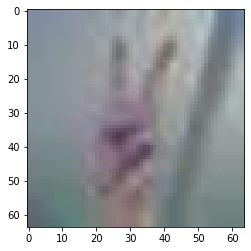

In [113]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

###2. 테스트 데이터 준비

In [114]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(f"   {len(images)} images to be resized.")

	target_size=(64,64)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(f"   {len(images)} images resized.")

for path in ['scissor', 'rock', 'paper']:
    image_dir_path = join(PIC, 'test', path)
    print(f"Directory : {path}")
    resize_images(image_dir_path)

Directory : scissor
   100 images to be resized.
   100 images resized.
Directory : rock
   100 images to be resized.
   100 images resized.
Directory : paper
   100 images to be resized.
   100 images resized.


In [115]:
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=64
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print(f"테스트 데이터(x_test)의 이미지 개수는 {idx}입니다.")
    return imgs, labels

image_dir_path = join(PIC, 'test')
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

테스트 데이터(x_test)의 이미지 개수는 300입니다.
x_test shape: (300, 64, 64, 3)
y_test shape: (300,)


#딥러닝 네트워크

딥러닝 네트워크 설계하기
- Sequential API 활용
- LeNet 딥러닝 네트워크 설계

In [138]:
# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=20

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(64,64,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_23 (Flatten)        (None, 6272)              0         
                                                                 
 dense_46 (Dense)            

딥러닝 네트워크 학습시키기

In [139]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
hist = model.fit(x_train, y_train, epochs=10)


Epoch 1/10
10/10 [==============================] - 1s 86ms/step - loss: 54.7120 - accuracy: 0.3000
Epoch 2/10
10/10 [==============================] - 1s 90ms/step - loss: 4.0444 - accuracy: 0.4000
Epoch 3/10
10/10 [==============================] - 1s 80ms/step - loss: 0.9005 - accuracy: 0.5867
Epoch 4/10
10/10 [==============================] - 1s 80ms/step - loss: 0.5858 - accuracy: 0.7700
Epoch 5/10
10/10 [==============================] - 1s 80ms/step - loss: 0.4388 - accuracy: 0.7967
Epoch 6/10
10/10 [==============================] - 1s 88ms/step - loss: 0.3020 - accuracy: 0.8900
Epoch 7/10
10/10 [==============================] - 1s 78ms/step - loss: 0.1921 - accuracy: 0.9467
Epoch 8/10
10/10 [==============================] - 1s 78ms/step - loss: 0.0978 - accuracy: 0.9900
Epoch 9/10
10/10 [==============================] - 1s 78ms/step - loss: 0.0556 - accuracy: 0.9933
Epoch 10/10
10/10 [==============================] - 1s 80ms/step - loss: 0.0400 - accuracy: 0.9967


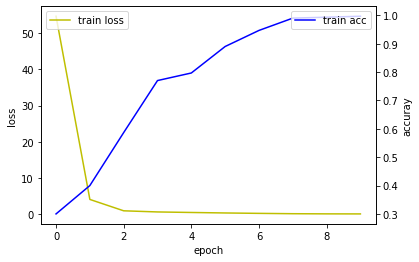

In [140]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='upper right')

plt.show()

딥러닝 네트워크 테스트하기

In [141]:
#모델 시험
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")


10/10 - 0s - loss: 7.2620 - accuracy: 0.4267 - 409ms/epoch - 41ms/step
test_loss: 7.262020587921143
test_accuracy: 0.4266666769981384


model.predict() 결과 :  [9.9977618e-01 1.5311839e-07 2.2370154e-04]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


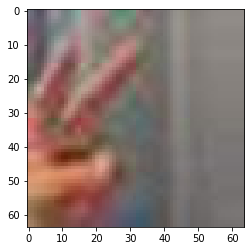

In [142]:
predicted_result = model.predict(x_test)
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

예측확률분포: [6.3259597e-03 3.7524362e-06 9.9367023e-01]
라벨: 1, 예측결과: 2


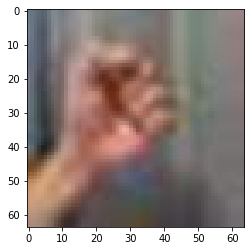

예측확률분포: [2.8370810e-05 3.9632248e-08 9.9997163e-01]
라벨: 1, 예측결과: 2


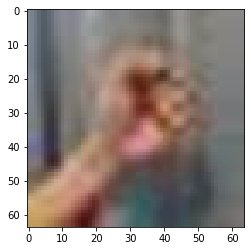

예측확률분포: [8.5084450e-01 1.7586790e-05 1.4913793e-01]
라벨: 2, 예측결과: 0


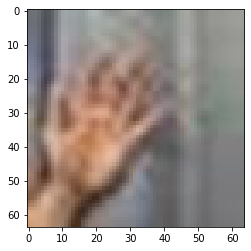

예측확률분포: [1.2438218e-04 2.5620006e-10 9.9987555e-01]
라벨: 1, 예측결과: 2


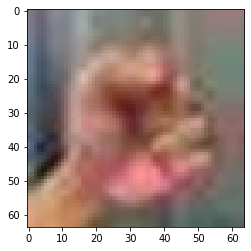

예측확률분포: [9.9994349e-01 1.7154333e-08 5.6494322e-05]
라벨: 1, 예측결과: 0


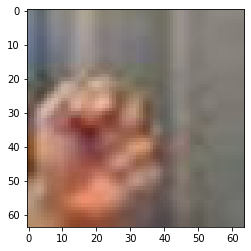

In [143]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

#회고

1. 이번 프로젝트에서 어려웠던 점
 - 모델 성능 개선 방법을 찾기가 쉽지 않음

2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점     
 1) 알아낸 점
   - keras 라이브러리 사용방법

 2) 모호한 점
   - Epoch > 10일 때 train acc가 0.333이 됨

3. 루브릭 평가 지표를 맞추기 위해 시도한 것들
 - 이미지 프레임 수 변경
 - 정규화
 - 하이퍼파라미터 변경

4. 다짐
 - 가위바위보 이미지 인식에 대한 다른 노트북 확인